In [11]:
from sklearn.preprocessing import normalize as norm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random

from korgorusz.optimizers import Momentum
from korgorusz.layers import *
from korgorusz.utils import *

In [12]:
# !wget https://data.deepai.org/mnist.zip
# !unzip mnist.zip
x,y,x_test,y_test=mnist("./",["train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz","t10k-images-idx3-ubyte.gz","t10k-labels-idx1-ubyte.gz"])

In [13]:
x.shape

(60000, 784)

In [14]:
np.random.seed(42)


x = norm(x)
y = one_hot(y, 10)
x, y = shuffle(x, y)

x_test = norm(x_test)
y_test = one_hot(y_test, 10)
x_test, y_test = shuffle(x_test, y_test)

x.shape,y.shape,x_test.shape,y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

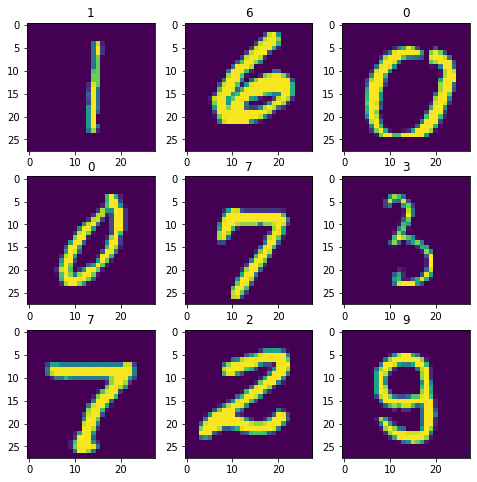

In [15]:
fig=plt.figure(figsize=(8,8))
col,rows=3,3
for i in range(1,col * rows + 1):
    j = random.randint(0,9999)
    fig.add_subplot(rows,col,i)
    plt.imshow(x_test[j].reshape(28,28))
    plt.title(f"{np.argmax(y_test[j])}")
plt.show()

In [16]:
class ModelLearn(Model):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers

    def forward(self, X):
        for l in self.layers:
            X, b = l.forward(X)
            self.add_derivative(b)
        return X

In [17]:
lr = 0.01
bs = 100
epoch = 50

In [18]:
ml = ModelLearn([
    Linear(784, 1024),
    ReLU(),
    Linear(1024, 1024),
    ReLU(),
    Linear(1024, 10),
    Softmax()])
optim = Momentum(lr)
loss_f = mse
losses = []

for e in tqdm(range(epoch)):
    running_loss=0.0
    x_num =0.0
    for x_b,y_b in minibatch(x,y,bs):
        pred = ml.forward(x_b)
        loss, d = loss_f(pred,y_b)
        running_loss+=loss
        x_num+=y_b.shape[0]
        ml.backpropagation(d)
        ml.update(ml.layers,optim)
    losses.append(running_loss/x_num)

100%|██████████| 52/52 [27:28<00:00, 31.70s/it]


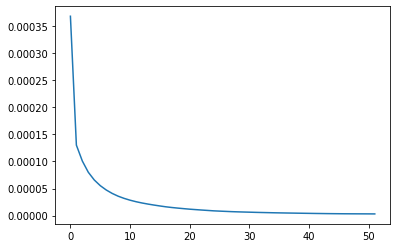

In [19]:
plt.plot(losses)
plt.show()

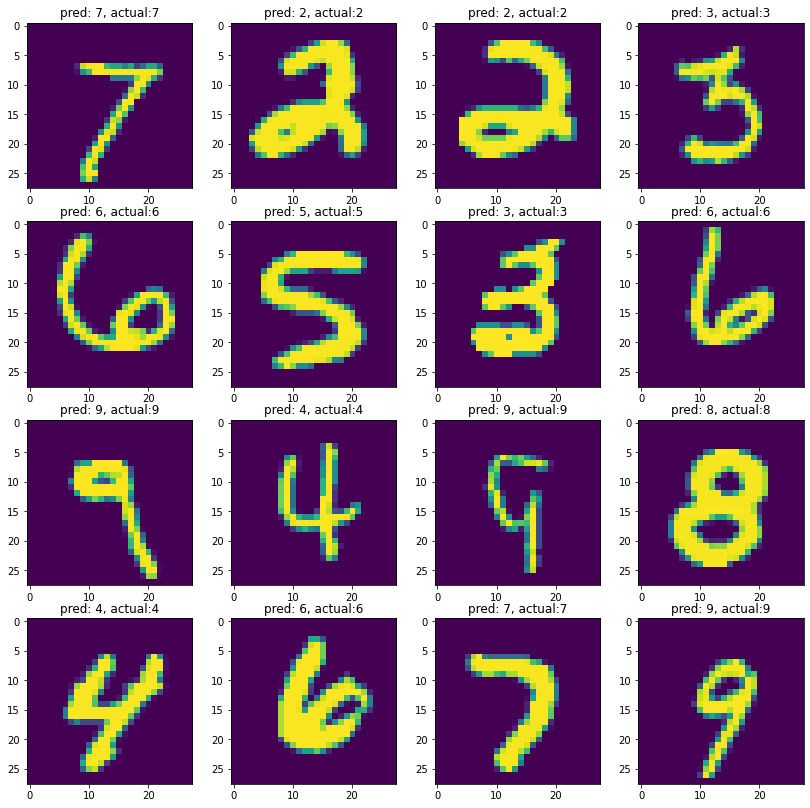

In [20]:
fig=plt.figure(figsize=(14,14))
col,rows=4,4
for i in range(1,col * rows + 1):
    j = random.randint(0,9999)
    pred = ml.forward(x_test[j].reshape(1, -1))
    fig.add_subplot(rows,col,i)
    plt.imshow(x_test[j].reshape(28,28))
    plt.title(f"pred: {np.argmax(pred)}, actual:{np.argmax(y_test[j])}")
plt.show()

In [21]:
wrong = 0
classes = dict()
for i in tqdm(range(len(x_test))):
    pred = ml.forward(x_test[i].reshape(1, -1))
    pred = pred.reshape(-1)
    if np.argmax(y_test[i]) != np.argmax(pred):
        wrong += 1
        if np.argmax(y_test[i]) in classes:
            classes[np.argmax(y_test[i])] += 1
        else:
            classes[np.argmax(y_test[i])] = 1
print(f"{round((wrong/len(x_test))*100, 2)}%, ", classes, wrong)

100%|██████████| 10000/10000 [00:14<00:00, 688.91it/s]

1.71%,  {9: 19, 5: 24, 8: 26, 1: 10, 0: 9, 6: 13, 7: 28, 4: 14, 2: 18, 3: 10} 171
